In [1]:
#from Tools import *
import numpy as np
import seaborn as sns
import pandas as pd
from BayesianInference import *
from random import Random
import random
from scipy.interpolate import interp1d
from scipy.stats import rv_continuous
from astropy.io import ascii
import emcee
import pathos.multiprocessing as multiproc
from multiprocessing import Pool
import corner
from IPython.display import display, Math
from palettable.cartocolors.qualitative import Antique_3
from matplotlib.colors import ListedColormap
import seaborn as sns
import glob 
import warnings

## MCMC Functions

In [24]:
def Likelihood(fesc,dfesc,Wo):
    """
    Likelihood : Probability of having a certain value of EW given the exponential parameters A and Wo

    Args:
        ew: Equivalent widths observed
        A : Parameter exponential (should depend on our other observables, such as uvslope and muv)
        Wo : Parameter exponential (should depend on our other observables, such as uvslope and muv)
    """
    dEW_2 = dfesc**2.
    p1 = 0#(1. - A) * np.exp(-0.5 * fesc**2./dEW_2) / np.sqrt(2.*np.pi) / dfesc
    X  = (dEW_2/Wo - fesc) / np.sqrt(2.) / dfesc
    p2 = 0.5 * 1 / Wo * np.exp(0.5*(dEW_2 - 2*fesc*Wo)/Wo**2.)*scipy.special.erfc(X)
    p = p1 + p2
    return p

def LikUp(wtab,dew,Wo):
        like = Likelihood(wtab,dew,Wo)
        return integrate.trapz(like,wtab)

def LikLow(wtab,dew,Wo):
        like = Likelihood(wtab,dew,Wo)
        return integrate.trapz(like,wtab)


def ParameterModel(physParams,mathParams):
    """
    ParameterModel: Given the physical parameters and the mathematical parameters, it returns the parameter of the model
    
    Input:
    - physParams: Physical parameters (Muv)
    - mathParams: Mathematical parameters (Constants of the model A and Wo)
    Output:
    - Parameter: Parameter of the model A or Wo
    """
    Muv,Beta=physParams[0],physParams[1]
    cMuv,cBeta,cte= mathParams[0],mathParams[1],mathParams[2]
    Parameter   =   ((Muv+20)*cMuv) + ((Beta+2)*cBeta)   +   cte 
    return Parameter


def Posterior(fesc,dfesc,physParams,mathParamsW,Detection_type,wtab):
    """
    """
    Wo=ParameterModel(physParams,mathParamsW)
    probLike=[]
    for i in range(0,len(Detection_type)):
        if Detection_type[i]=="LyaHa":
            p   =   Likelihood(fesc[i],dfesc[i],Wo[i])
        if Detection_type[i]=="Ha":
            p   =   LikUp(wtab[i],dfesc[i],Wo[i])
        if Detection_type[i]=="Lya":
            p   =   LikLow(wtab[i],dfesc[i],Wo[i])
        if np.isnan(p)==True:
            continue

        probLike.append(p)
        
    return np.array(probLike)


def log_prior(theta,physParams):
    # I can put priors here or in the equation in the BInf object 
    Wuv,Wb,Wc= theta

    W =   ParameterModel(physParams,[Wuv,Wb,Wc])
    #print(A,W)
    if (W > 0.).all() and (W < 0.3).all():
        return 0.0 
    return -np.inf

def log_likelihood(theta,y,yerr,physParams,Detection_type,wtab):
    Wuv,Wb,Wc= theta
    model = Posterior(y,yerr,physParams,[Wuv,Wb,Wc],Detection_type,wtab) # Does thus have to be exp, so it gets outside the logaritm?
    return np.sum(np.log(model))


def log_probability(theta, y, yerr,Muv,Beta,Detection_type,wtab):
    DrawnphysParams=[Muv,Beta]
    lp = log_prior(theta,DrawnphysParams)
    if not np.isfinite(lp):
        return -np.inf
    
    lL=log_likelihood(theta, y, yerr,DrawnphysParams,Detection_type,wtab)
    #print(lL)
    if np.isnan(lL)==True:
        return -np.inf
    else:
        return lp + lL

## load Data

In [25]:

Catalog=ascii.read('../../A-Catalogs/Binospec-Candels.cat')
mask=np.isnan(Catalog["fesc"])==False
Catalog=Catalog[mask]
mask=Catalog["EWLya"]<500
Catalog=Catalog[mask]
mask=Catalog["Muv"]>-23.5
Catalog=Catalog[mask]

In [26]:
%load_ext autoreload
%autoreload

Muv=Catalog["Muv"]

Beta=Catalog["slope"]
BInf=BayesInf()
BInf.Muv=Muv
fesc_obs=Catalog["fesc"]
BInf.fesc_obs=np.array(fesc_obs)

BInf.dfesc=Catalog["dfesc"]
BInf.typesCat=Catalog["Type"]
Detection_type=BInf.DetectionTypeReal()
dfesc=[]
for gal in Catalog:
    if np.isnan(gal["dfesc"])==False:
        dfesc.append(gal["dfesc"])
    else:
        dfesc.append(np.nanmedian(Catalog["dfesc"]))
dfesc=np.array(dfesc)
Detection_type=BInf.DetectionTypeReal()
wtab=BInf.GenerateWtab_real()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/A-Project/D-EWModel/Simple PhotometryRebuild 15 May fesc Wonly/BayesianInference.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [27]:
import seaborn as sns
%load_ext autoreload
%autoreload
# Set the seaborn theme and font scale
sns.set_theme(style="ticks",font_scale=2)
plt.rcParams["figure.figsize"] = (9,6.)


steps=2500
nwalkers=15
inValuesW=[0.02,-0.02,0.15]
inValues=inValuesW
pos = inValues+ [0.01,0.01,0.01] * np.random.randn(nwalkers,len(inValues) )
nwalkers, ndim = np.shape(pos)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(fesc_obs,dfesc,Muv,Beta,Detection_type,wtab)
)
sampler.run_mcmc(pos, steps, progress=True)



  0%|          | 0/2500 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
<ipython-input-24-9583000bf585>:13: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * 1 / Wo * np.exp(0.5*(dEW_2 - 2*fesc*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-24-9583000bf585>:13: RuntimeWarning: overflow encountered in multiply
  p2 = 0.5 * 1 / Wo * np.exp(0.5*(dEW_2 - 2*fesc*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-24-9583000bf585>:13: RuntimeWarning: invalid value encountered in multiply
  p2 = 0.5 * 1 / Wo * np.exp(0.5*(dEW_2 - 2*fesc*Wo)/Wo**2.)*scipy.special.erfc(X)
  0%|          | 2/2500 [00:00<02:05, 19.88it/s]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 2500/2500 [01:19<00:00, 31.64it/s]


State([[ 0.02069118 -0.02262776  0.20775973]
 [-0.00608334 -0.02586226  0.23511547]
 [ 0.04047404 -0.04013329  0.21401548]
 [ 0.01660035  0.00353529  0.25831819]
 [ 0.00711994 -0.03896548  0.19957988]
 [ 0.03695339  0.00941965  0.20970105]
 [ 0.02040026 -0.03038775  0.21325552]
 [ 0.01419967 -0.04598089  0.23022627]
 [-0.02742234 -0.03146134  0.18257698]
 [ 0.05356411 -0.00760817  0.21002162]
 [ 0.00319548 -0.04528095  0.22290524]
 [-0.00750768 -0.02895493  0.15482612]
 [ 0.0371602   0.00803397  0.22094642]
 [ 0.03446858  0.00257469  0.20684042]
 [-0.02336767 -0.02551211  0.20335812]], log_prob=[-27.68961142 -27.29813471 -28.45727888 -27.72692248 -27.82700577
 -28.01301268 -27.58598347 -27.31496468 -28.39992311 -28.40274941
 -27.27842747 -30.07170342 -27.80003464 -27.98262759 -27.771075  ], blobs=None, random_state=('MT19937', array([ 208866383,  889148361, 2025481998, 2615740206, 2667540918,
       1774624118, 4196131220, 4030093509, 4070610707, 2961023409,
       1070958399, 12256291

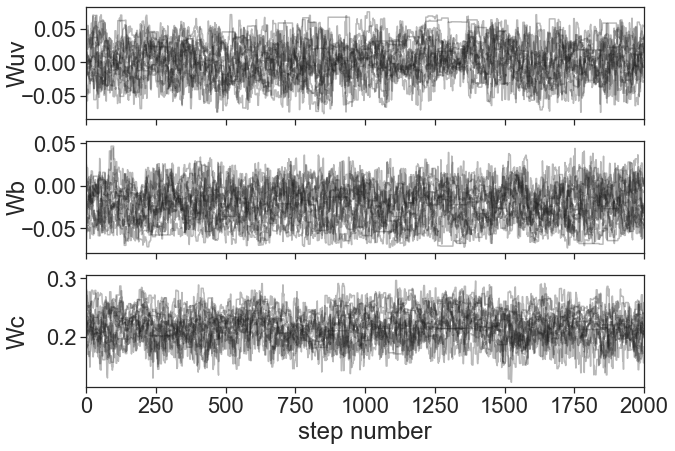

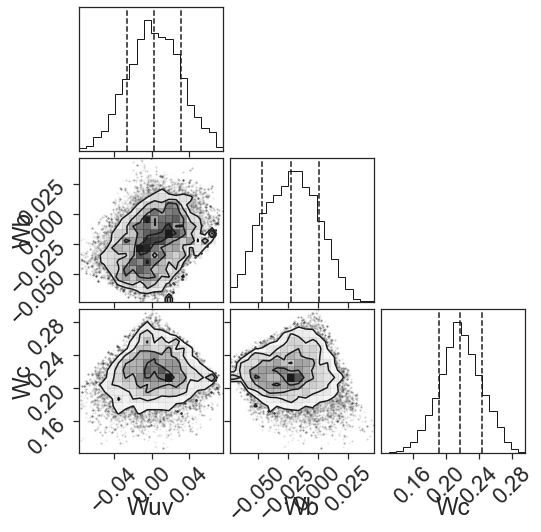

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [29]:
dis=500
labels = ["Wuv","Wb","Wc"]
fig, axes = plt.subplots(len(labels), figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=dis)
logProb=sampler.get_log_prob(discard=dis)
maskWalkers=[False if np.isinf(logProb[steps-dis-10,i]) else True for i in range(0,nwalkers)]
samples=np.array([s[maskWalkers] for s in samples])
for i in range(len(labels)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.show()


ndim=len(labels)
samples = sampler.get_chain(discard=dis)
samples=np.array([s[maskWalkers] for s in samples])
samples=samples.reshape(np.shape(samples)[0]*np.shape(samples)[1],np.shape(samples)[2])

fig = corner.corner(
    samples, labels=labels,quantiles=[.16,.50,.84]
)
plt.show()

results=[]
r16,r84=[],[]
for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    results.append(mcmc[1])
    r16.append(mcmc[0])
    r84.append(mcmc[2])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))